# Earthdata Webinar: Examining Hurricane Milton's Milestones with NASA's GES DISC Datasets

Authors: Chris Battisto (christopher.m.battisto@nasa.gov), Lauren Hill-Beaton (lauren.k.hill-beaton@nasa.gov)

### Overview

This notebook contains methods for accessing and analyzing four different TROPICS collections (URAD, MIRS, PRPS, and TCIE) using Python. It utilizes the `earthaccess` and `pydap` libraries to search, create, and access [OPeNDAP](https://www.earthdata.nasa.gov/engage/open-data-services-software/earthdata-developer-portal/opendap) variable subsets and [Earthdata Cloud-hosted](https://disc.gsfc.nasa.gov/information/documents?title=Migrating%20to%20the%20Cloud) granules that will be streamed to kernel memory for later analysis. After the data has been filtered using quality control flags, variables are plotted to highlight various attributes of Hurricane Milton in October 2024.


### Prerequisites

- A valid [Earthdata Login account](https://urs.earthdata.nasa.gov/)
    - Approval of the "NASA GESDISC DATA ARCHIVE" application by following this guide: https://disc.gsfc.nasa.gov/earthdata-login
    - Generation of the `.netrc` and `.dodsrc` files (both files will be generated in this notebook)
- Python >=3.10
- [Xarray](https://docs.xarray.dev/en/stable/)
- [Pydap](https://pydap.github.io/pydap/intro.html)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [NumPy](https://numpy.org/)
- [earthaccess](https://github.com/nsidc/earthaccess)


You can run this tutorial in your browser using Colab:<br>

<a target="_blank" href="https://colab.research.google.com/github/nasa/gesdisc-tutorials/blob/jan-2025-earthdata-webinar/webinars/January_29th_2025_Earthdata_Webinar.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 1. Install Packages and Import Libraries

In [ ]:
! pip install pydap -q
! pip install earthaccess -q
! pip install cartopy -q

In [92]:
import earthaccess
import xarray as xr
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pydap.client import open_url
from base64 import b64encode
from getpass import getpass


### 2. Authenticate with Earthdata Login Servers

In [ ]:
# Earthdata Login URL for obtaining the token, and creating one if it doesn't exist
url = 'https://urs.earthdata.nasa.gov/api/users/find_or_create_token'

# Earthdata Login credential prompts
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

# Get credentials from user input
username = getpass(prompt=prompts[0])
password = getpass(prompt=prompts[1])

# Encode credentials using Base64
credentials = b64encode(f"{username}:{password}".encode('utf-8')).decode('utf-8')

# Headers with the Basic Authorization
headers = {
    'Authorization': f'Basic {credentials}'
}

# Make the POST request to get the token
response = requests.post(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the response JSON to get the token
    token_info = response.json()
    token = token_info.get("access_token")
    print("Token retrieved successfully")

    # Define the path for the .edl_token file in the home directory
    token_file_path = os.path.join(os.path.expanduser("~"), ".edl_token")

    print(f"Token stored in memory")

else:
    print("Failed to retrieve token:", response.text)

# Create session for OPeNDAP-EDL authentication
my_session = requests.Session()
my_session.headers = {
    'Authorization': f'Bearer {token}'
}

Token retrieved successfully
Token stored in memory


### 3. Search for Granules

Due to the nature of Level 2 granules, we recommend using the [Earthdata Search graphical web tool](https://search.earthdata.nasa.gov) to search for granules over your area and time of interest. The Earthdata Search tool uses the [Content Metadata Repository (CMR)](https://www.earthdata.nasa.gov/about/esdis/eosdis/cmr#:~:text=NASA's%20Common%20Metadata%20Repository%20CMR,system%20for%20all%20EOSDIS%20metadata.) to return granules that are inside the specified bounding box, or time period. Please note that this is ***not*** a subsetting service; variable subsetting will be performed before downloading using the OPeNDAP service, and spatiotemporal subsetting will be performed in this notebook using `Xarray`. 

Below, we will create three queries for the PRPS, URAD, and MIRS granules that we want URLs for, only using the granule title as specified in the CMR Search metadata. Then, we create two, spatiotemporal queries for the TCIE granules that we want, which will be used to create a time series plot.

To view the CMR search results and metadata of each granule, please visit these links below:

- [TROPICS06MIRSL2B_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3255752538-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-08T00%3A00%3A00.000Z%2C2024-10-08T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3302241470-GES_DISC&q=TROPICS06MIRSL2B_1.0&sb[0]=-93.39574%2C18.96392%2C-82.50014%2C27.39828&tl=1737127400!3!!&lat=10.125629097694798&long=-202.07607456913408&zoom=1)
- [TROPICS06PRPSL2B_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3254839721-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-09T00%3A00%3A00.000Z%2C2024-10-09T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3267503566-GES_DISC&q=TROPICS06PRPSL2B_1.0&sb[0]=-85.31145%2C24.65829%2C-78.21174%2C30.63263&tl=1737127400!3!!&lat=25.595846992315998&long=-148.28847666260972)
- [TROPICS03URADL2A_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3179859133-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-08T00%3A00%3A00.000Z%2C2024-10-08T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3261964279-GES_DISC&q=TROPICS03URADL2A_1.0&sb[0]=-85.45524%2C24.51801%2C-78.707%2C30.84377&tl=1737127400!3!!&lat=1.6864515038420083&long=-261.21314640338124&zoom=0)
- [TROPICS03TCIEL2B_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3279630448-GES_DISC&pg[0][x]=3285441291!GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-08T00%3A00%3A00.000Z%2C2024-10-09T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3281658034-GES_DISC&q=TROPICS03TCIEL2B_1.0&sb[0]=-85.45524%2C24.51801%2C-78.707%2C30.84377&tl=1737127400!3!!&lat=46.67009496377723&long=-263.46256056599094&zoom=0)


In [318]:
# 2024-10-08 07:16Z to 2024-10-08 08:51Z
urad_results = earthaccess.search_data(
    short_name="TROPICS03URADL2A",
    version="1.0",
    granule_ur="TROPICS03URADL2A.1.0:TROPICS03.URAD.L2A.Orbit07595.V01-24.ST20241008-071651.ET20241008-085106.CT20241008-213125.nc"
)

# 2024-10-08 18:26Z to 2024-10-08 20:00Z
mirs_results = earthaccess.search_data(
    short_name="TROPICS06MIRSL2B",
    version="1.0",
    granule_ur="TROPICS06MIRSL2B.1.0:TROPICS06.MIRS.L2B.Orbit07877.V02-07.ST20241008-182618.ET20241008-200022.CT20241115-012205.nc"
)

# 2024-10-09 14:49Z to 2024-10-09 16:23Z
prps_results = earthaccess.search_data(
    short_name="TROPICS06PRPSL2B",
    version="1.0",
    granule_ur="TROPICS06PRPSL2B.1.0:TROPICS06.PRPS.L2B.Orbit07890.V04-02.ST20241009-144903.ET20241009-162306.CT20241011-213359.nc"
)

# Query 03 and 06 TCIE collections
tcie_03_results = earthaccess.search_data(
    short_name="TROPICS03TCIEL2B",
    version="1.0",
    bounding_box=(-98.75, -76.5, 17.25, 31.5),
    temporal=("2024-10-06", "2024-10-14")
)

tcie_06_results = earthaccess.search_data(
    short_name="TROPICS06TCIEL2B",
    version="1.0",
    bounding_box=(-98.75, -76.5, 17.25, 31.5),
    temporal=("2024-10-06", "2024-10-14")
)


### 4. Create OPeNDAP Variable Subset URLs for PRPS, MIRS, and URAD

For granules that are quite large, specifically PRPS, MIRS, and URAD, we can utilize the OPeNDAP service to only subset the variables that we want, and "stream" them to our kernel rather than downloading them. Below, we parse out the OPeNDAP URLs from our `earthaccess` search queries and append the variable subsets to each link, before accessing and plotting them.

To view the variables available in each collection, and to view the OPeNDAP web subsetter tool, please visit the Dataset Landing Page for each collection, click the "OPeNDAP" button on the right of the page, and select the top-level granule. You will be see each variable and their attributes. We will copy and paste the names of the variables that we want into each OPeNDAP URL creation routine, where they are formatted as ["constraint expressions"](https://docs.opendap.org/index.php/UserGuideOPeNDAPMessages#:~:text=The%20constraint%20expression%20attached%20to,of%20interest%20from%20a%20dataset.), denoted by the variable `ce`. Finally, we will print the links, which will be used with the `pydap` library to "stream" to the notebook session, rather than downloading them.

It is ***critical*** to note that the constraint expressions for downloading the subsets, using tools like `requests`, is slightly different than using `pydap`. When using a tool like `requests`, `.dap.nc4` must be appended to the end of each root URL before the constraint expressions are specified, or else an error will occur. However, when using `pydap` like in this notebook, or simply clicking the printed links, adding `.dap.nc4` will cause a 404 error.

To learn more about how the OPeNDAP service is being migrated to the Earthdata Cloud, please visit [this document](https://disc.gsfc.nasa.gov/information/documents?title=OPeNDAP%20In%20The%20Cloud).

#### 4a. Subset TROPICS06URADL2A

Note that because URAD is a Level 2A collection originally in NetCDF3 format, it does not have DAP4 constraint expression support, and uses a DAP2 constraint expression instead.

In [221]:
for itm in urad_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below
            # NOTE: This is a DAP2 constraint expression, not a DAP4 constraint expression, like in other cells
            ce = "?{},{},{},{}".format("brightness_temperature", "calQualityFlag", "longitude", "latitude")
            urad_url = urls['URL'] + ce
            print(urad_url)

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2A/TROPICS03URADL2A.1.0/2024/282/TROPICS03.URAD.L2A.Orbit07595.V01-24.ST20241008-071651.ET20241008-085106.CT20241008-213125.nc?brightness_temperature,calQualityFlag,longitude,latitude


#### 4b. Subset TROPICS06PRPSL2A

In [171]:
for itm in prps_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below. "ce" refers 
            ce = "?dap4.ce={}%3B{}%3B{}%3B{}".format("rain_rate", "prps_flag", "losLon", "losLat")
            prps_url = urls['URL'] + ce
            print(prps_url)

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS06PRPSL2B.1.0/2024/283/TROPICS06.PRPS.L2B.Orbit07890.V04-02.ST20241009-144903.ET20241009-162306.CT20241011-213359.nc?dap4.ce=rain_rate%3Bprps_flag%3BlosLon%3BlosLat


#### 4c. Subset TROPICS06MIRSL2A

In [172]:
for itm in mirs_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below. "ce" refers 
            ce = "?dap4.ce={}%3B{}%3B{}%3B{}".format("TPW", "Qc", "Latitude", "Longitude")
            mirs_url = urls['URL'] + ce
            print(mirs_url)

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS06MIRSL2B.1.0/2024/282/TROPICS06.MIRS.L2B.Orbit07877.V02-07.ST20241008-182618.ET20241008-200022.CT20241115-012205.nc?dap4.ce=TPW%3BQc%3BLatitude%3BLongitude


### Analysis 1: Plotting Brightness Temperature After Peak Strength using TROPICS06URADL2A

Brightness temperature can be used to determine hurricane strength, and is provided in the TROPICS06URADL2A
collection. Hurricane Milton achieved peak strength just after 00Z on October 8th, where it achieved Category
5 strength, persisting until around 06Z. 

First, we will open the dataset using `pydap`, making sure to specify `protocol="dap2"` for this particular collection. 
Then, to verify that we have loaded the data, we will simply print out the children by calling `print(ds)`.

In [261]:
# Open the dataset using the request session containing your token
ds = open_url(urad_url, session=my_session, protocol="dap2")

print(ds.tree())

<DatasetType with children 'brightness_temperature', 'latitude', 'longitude', 'calQualityFlag'>


After the dataset object is loaded, we must specify the channel and bands used for our analysis. We will select channel 12 (204.8 GHz), which represents radiation in the upper atmosphere, and its corresponding 5th band.

For the TROPICS06URADL2A, quality control flags for data quality are represented by data quality control bits (numbered 2-5) in the `calQualityFlag` variable, as defined by the [documentation](https://docserver.gesdisc.eosdis.nasa.gov/public/project/TROPICS/TROPICS_UserGuide_base_Sept2023.pdf#page=33). The cell below will search and parse out "bad data" through each scan and spot within the scan before plotting. For quality control, if 2 or more bits are flagged, then the spot data is masked.

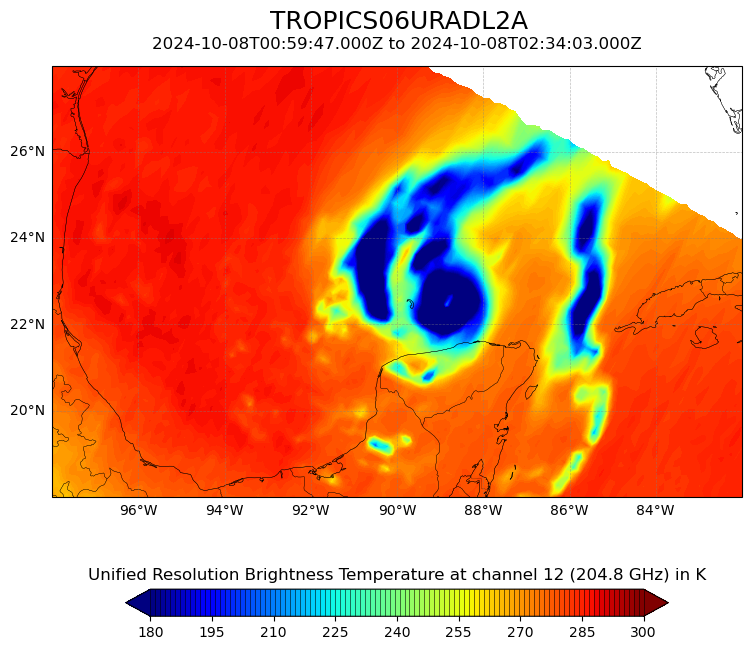

In [263]:
cs = 12 #The channel
bas = 5  #The band

channel = [1,2,3,4,5,6,7,8,9,10]
band = [1,2,3,4,5]
ghz_list = [91.655,114.50,115.95,116.65,117.25,117.80,118.24,118.58,184.41,186.51,190.31,204.8]

atemp_old = np.array(ds['brightness_temperature'][cs-1,:,:])[0]
qfc = np.array(ds['calQualityFlag'][cs-1,:,:])[0]
lat_old = np.array(ds['latitude'][bas-1,:,:])[0] #5 bands
lon_old = np.array(ds['longitude'][bas-1,:,:])[0] #5 bands

#Scans and Spots Size
sc = atemp_old.shape[0]
sp = atemp_old.shape[1]

#Quality Flag zero array
atemp = np.zeros((sc,sp))

# Parse through scans and spots to remove bad data
for scans in range(sc):
    for spots in range(sp):
        qfc_value = qfc[scans, spots]
        qfc_bits = np.unpackbits(np.array([qfc_value], dtype=np.uint8))  # Get full bit array
        bad_bits = sum(qfc_bits[2:6])  # Count bits 2-5 that are set

        if bad_bits < 2:  # If 2 or more bits are flagged, the data is considered "bad" and written as nan
            atemp[scans, spots] = atemp_old[scans, spots]
        else:
            atemp[scans, spots] = np.nan

#Plot
fig,(ax) = plt.subplots(1, 1, figsize=(10, 8),subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linewidth=0.15,edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.2,edgecolor='black')
ax.coastlines(resolution='10m', color='black',linewidth=0.3)
ax.set_extent([-98, -82, 18, 28], crs=ccrs.PlateCarree())

levels = np.linspace(180,300,100)
level_ticks = np.arange(180, 305, 15)
cmap=plt.get_cmap('jet')

# Mask out lines that wrap around the globe (plotting artifact)
mask = (lon_old > 179) | (lon_old < -179) | (lat_old > 89)
masked_atemp = np.ma.array(atemp, mask=mask)

contours = ax.contourf(lon_old, lat_old, masked_atemp, levels, 
                        cmap=cmap,vmin=min(levels), vmax=max(levels), extend='both')

#Colorbar 
clb = plt.colorbar(contours, orientation='horizontal', extend='neither',
                  ticks=level_ticks, shrink=0.7, drawedges=True, pad=0.15)
clb.ax.xaxis.set_label_position('top')
clb.set_label(label='Unified Resolution Brightness Temperature at channel '+ str(cs) +' (' + str(ghz_list[cs-1]) + ' GHz) in K',size=12,labelpad=7.25)#*

# Add gridlines with latitude and longitude labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Customize which sides to show labels on
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

gl.xlocator = plt.MaxNLocator(nbins=8)  # Auto space longitude ticks
gl.ylocator = plt.MaxNLocator(nbins=6)  # Auto space latitude ticks

#Titles
plt.suptitle('TROPICS06URADL2A',x=0.515,y=0.95,fontsize=18)
ax.set_title('2024-10-08 07:16Z to 2024-10-08 08:51Z\n', fontsize=12,y=0.98,ha='center')#*
plt.show()

### Analysis 2: Plotting Derived Rain Rates using TROPICS06PRPSL2B

The PRPS collection derives rain rates in mm/hr for each spot in the swath. For quality control, if only 1 data quality control bit is flagged, or the value is negative, then the spot is masked.

In [322]:
# Open the dataset using the request session containing your token
ds = open_url(prps_url, session=my_session)

print(ds.tree())

.TROPICS06.PRPS.L2B.Orbit07890.V04-02.ST20241009-144903.ET20241009-162306.CT20241011-213359.nc
├──losLat
├──losLon
├──rain_rate
└──prps_flag
None


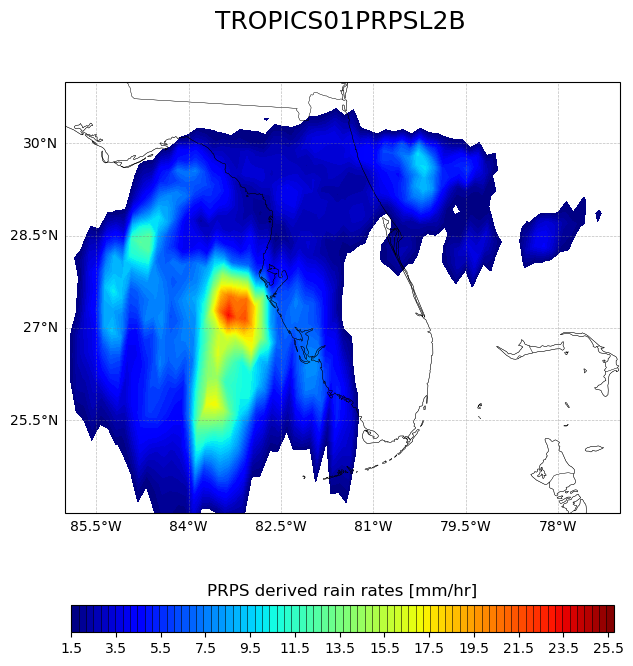

In [289]:
rain_r = np.array(ds['rain_rate'][:,:])
qfc = np.array(ds['prps_flag'][:,:])
lat_old = np.array(ds['losLat'][:,:])
lon_old = np.array(ds['losLon'][:,:])

#Scans and Spots Size
sc = rain_r.shape[0]
sp = rain_r.shape[1]

#Quality Flag zero arrays
lat = np.zeros((sc,sp))
lon = np.zeros((sc,sp))
rain_rn = np.zeros((sc,sp))

#Create condensed list of all quality flag uint8 values
count=0
empty_list=[]
for number in qfc_l:
    if(number not in empty_list):
        count+=1
        empty_list.append([number])

arr = np.array(empty_list, dtype=np.uint8)

#Unpack uint8 into bits into another list
bits = np.unpackbits(arr,axis=1)

#Create a loop with conditions that will parse out and identify bad data
bad_uint=[]
for row in range(0,len(arr)):
    for ind in range(2,6): #Only Bits 2-5
        # If there is one flag, mask spot
        if bits[row][ind] == 1:
            if(arr[row] not in bad_uint):
                bad_uint.append(arr[row][0])

#Remove Bad Data
for scans in range(0,sc):
        for spots in range(0,sp):
                # Remove negative (invalid) data and flagged "bad" data
                if (rain_r[scans][spots] < 0) or (qfc[scans][spots] in bad_uint):
                        rain_rn[scans][spots]=np.nan
                else:
                        rain_rn[scans][spots]=rain_r[scans][spots]

#Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linewidth=0.15,edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.2,edgecolor='black')
ax.coastlines(resolution='10m', color='black',linewidth=0.3)
ax.set_extent([-86, -77, 24, 31], crs=ccrs.PlateCarree())

levels = np.linspace(1.5,25.75,75)
level_ticks = np.arange(1.5, 25.75, 2)
cmap=plt.get_cmap('jet')

contours = ax.contourf(lon_old,lat_old,rain_rn,levels,cmap=cmap,vmin=min(levels), vmax=max(levels))

clb = plt.colorbar(contours, orientation='horizontal', extend='neither',
                  ticks=level_ticks, shrink=0.7, drawedges=True, pad=0.15)
clb.ax.xaxis.set_label_position('top')
clb.set_label(label='PRPS derived rain rates [mm/hr]',size=12,labelpad=7.25)

# Add gridlines with latitude and longitude labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Customize which sides to show labels on
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

gl.xlocator = plt.MaxNLocator(nbins=8)  # Auto space longitude ticks
gl.ylocator = plt.MaxNLocator(nbins=6)  # Auto space latitude ticks

#Titles
plt.suptitle('TROPICS06PRPSL2B',x=0.51,y=0.97,fontsize=18)
ax.set_title('2024-10-09 14:49Z to 2024-10-09 16:23Z\n', fontsize=12,y=0.98,ha='center')#*
plt.show()

### Analysis 3: Plotting Total Precipitable Water using TROPICS06MIRSL2B

Soon after peak strength, Hurricane Milton was observed to have spots in MIRS with total precipitable water values exceeding 200mm (~7.8 inches). For quality control, if 2 or more bits are flagged, and the data is positive, then the spot data is masked. Additionally, TPW values contain a `scale_factor` which the data should be multiplied by (in this case, 0.1).

In [ ]:
# Open the dataset using the request session containing your token
ds = open_url(mirs_url, session=my_session)

print(ds.tree())

<DatasetType with children 'Latitude', 'Longitude', 'Qc', 'TPW'>


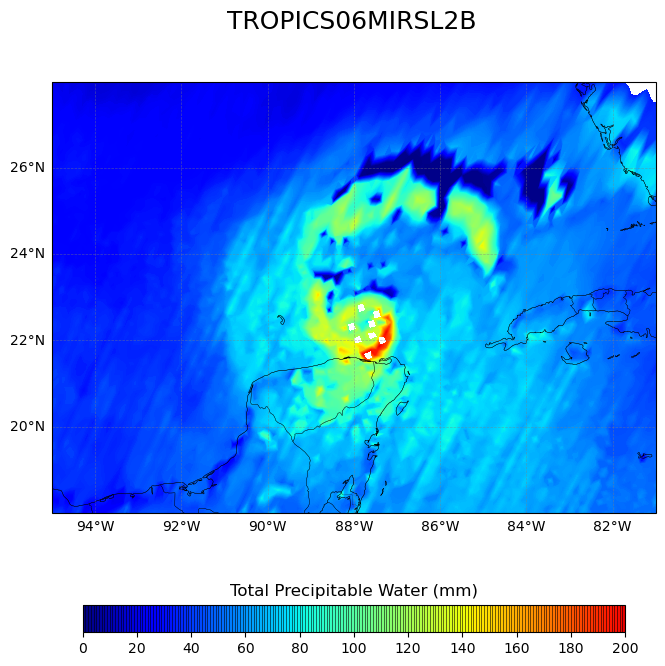

In [ ]:
cs = 12 #The channel
bas = 5 #The band

channel = [1,2,3,4,5,6,7,8,9,10]
band = [1,2,3,4,5]
ghz_list = [91.655,114.50,115.95,116.65,117.25,117.80,118.24,118.58,184.41,186.51,190.31,204.8]

TPW_old = np.array(ds['TPW'][:,:]).astype('float') * 0.1 # Multiply since scale factor is 0.1
qfc = np.array(ds['Qc'][:,:,0])
lat_old = np.array(ds['Latitude'][:,:])
lon_old = np.array(ds['Longitude'][:,:])

#Scans and Spots Size
sc = TPW_old.shape[0]
sp = TPW_old.shape[1]

#Quality Flag zero arrays
lat = np.zeros((sc,sp))
lon = np.zeros((sc,sp))
atemp = np.zeros((sc,sp))

# Loop through the data and overwrite bad values with NaN
for scans in range(sc):
    for spots in range(sp):
        # Allow for less than 2 data flags (less strict)
        if qfc[scans, spots] < 2 and TPW_old[scans, spots] > 0:  # Skip good data, select quality control flag 0
            continue
        else:
            TPW_old[scans, spots] = np.nan  # Overwrite bad data with NaN

# Mask out lines that wrap around the globe (plotting artifact)
mask = (lon_old > 179) | (lon_old < -179) | (lat_old > 89)
masked_TPW = np.ma.array(TPW_old, mask=mask)

# Updated levels and ticks
levels = np.linspace(0, 200, 201)
level_ticks = np.arange(0, 201, 20)  # Now goes up to 220

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linewidth=0.15, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor='black')
ax.coastlines(resolution='10m', color='black', linewidth=0.3)
ax.set_extent([-95, -81, 18, 28], crs=ccrs.PlateCarree())

# Adjust colormap
cmap = plt.get_cmap('jet')
contours = ax.contourf(lon_old, lat_old, masked_TPW, levels=levels, cmap=cmap, vmin=0, vmax=220)

# Colorbar with proper extensions
clb = plt.colorbar(contours, orientation='horizontal', extend='both',
                   ticks=level_ticks, shrink=0.7, drawedges=True, pad=0.15)
clb.ax.xaxis.set_label_position('top')
clb.set_label(label='Total Precipitable Water (mm)', size=12, labelpad=7.25)

# Add gridlines with dynamic spacing
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

gl.xlocator = plt.MaxNLocator(nbins=8)  # Auto space longitude ticks
gl.ylocator = plt.MaxNLocator(nbins=6)  # Auto space latitude ticks

# Title
plt.suptitle('TROPICS06MIRSL2B', x=0.51, y=0.97, fontsize=18)
ax.set_title('2024-10-08 18:26Z to 2024-10-08 20:00Z\n', fontsize=12,y=0.98,ha='center')#*
plt.show()


### Analysis 4: Creating and Plotting a Time Series of Max Winds/MSLP for Hurricane Milton using TROPICS03TCIEL2B and TROPICS06TCIEL2B

Unlike the PRPS, MIRS, and URAD collections, the Tropical Cyclone Intensity Estimate (TCIE) collection tracks identified hurricanes (organized by storm number) and provides single values of the storm center latitude/longitude, mean sea-level pressure (MSLP), maximum winds, and others. Because coverage might be limited between cubesats, we will query both TROPICS03 and TROPICS06 over the Gulf and during the lifecycle of Hurricane Milton.

The size of the granules are quite small (~35KB each), so the OPeNDAP service is not necessary. Instead, we can use `earthaccess` to "stream" the full granules to memory, and then open them as `Xarray` datasets. `Xarray` provides the ability to easily create dimensions and concatenate multiple files together. Because we are accessing from a different service, we will need to authenticate again, using `earthaccess.login()`, which will prompt you for your username and password, before storing them in a `.netrc` file.

Please note that the source of the granules is the Earthdata Cloud, so we can run this operation in parallel, which is a default option in the `earthaccess` library.

In [323]:
# Authenticate with cloud servers
auth = earthaccess.login()

# Create file system objects for each TCIE results query
fs_03 = earthaccess.open(tcie_03_results)
fs_06 = earthaccess.open(tcie_06_results)

QUEUEING TASKS | :   0%|          | 0/37 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/37 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/37 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/61 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/61 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/61 [00:00<?, ?it/s]

Once the granules are loaded, we can prepare them for concatenation. Because the data does not contain a time dimension, we must extract the swath start time from the global attributes of the granule (stored in `ds.attrs`), and assign them to a new dimension that we will define as `time`. After we loop through each granule and assign the dimension, we concatenate them into a single combined `Xarray` dataset, along the newly created `time` dimension. Finally, we sort each time step in order.

In [324]:
# Helper function to process datasets
def open_and_assign_time(file_objects):
    datasets = []
    for file_obj in file_objects:
        ds = xr.open_dataset(file_obj)
        
        # Extract attributes containing time
        start_date = ds.attrs["RangeBeginningDate"]
        start_time = ds.attrs["RangeBeginningTime"]
        
        # Combine date and time into a single string
        timestamp_str = f"{start_date}T{start_time}"  # ISO 8601 format
        timestamp = pd.to_datetime(timestamp_str)  # Let pandas infer the format
        
        # Assign the timestamp as a coordinate
        ds = ds.assign_coords(time=timestamp).expand_dims("time")
        datasets.append(ds)
    return datasets

# Open and process both datasets
datasets_03 = open_and_assign_time(fs_03)
datasets_06 = open_and_assign_time(fs_06)

# Concatenate datasets along time
ds_tcie_03_combined = xr.concat(datasets_03, dim="time")
ds_tcie_06_combined = xr.concat(datasets_06, dim="time")

# Combine the two datasets into one along the time dimension
final_combined = xr.concat([ds_tcie_03_combined, ds_tcie_06_combined], dim="time")

# Sort by time
final_combined = final_combined.sortby("time")

# Check the result
print(final_combined)

<xarray.Dataset>
Dimensions:       (time: 98, lat: 1, lon: 1, vmax: 1, qflag1: 1, stm_num: 1,
                   mslpd: 1)
Coordinates:
  * time          (time) datetime64[ns] 2024-10-06T03:43:20 ... 2024-10-14T17...
Dimensions without coordinates: lat, lon, vmax, qflag1, stm_num, mslpd
Data variables:
    storm_basin   (time) |S1 b'W' b'W' b'A' b'A' b'A' ... b'A' b'A' b'A' b'A'
    latitude      (time, lat) float64 17.89 17.75 12.32 ... 18.65 16.76 17.3
    longitude     (time, lon) float64 146.2 145.4 -37.21 ... -38.58 -39.36
    max_wind      (time, vmax) int32 31 43 69 94 36 93 96 ... 39 44 42 28 36 33
    quality_flag  (time, qflag1) int8 0 0 1 0 0 0 0 1 2 0 ... 0 0 0 0 0 0 0 0 0
    stmnum        (time, stm_num) int16 21 21 13 12 14 12 ... 16 16 16 16 16 16
    mslp          (time, mslpd) int32 1006 997 977 961 ... 1004 1012 1010 1010
Attributes: (12/32)
    description:                    TCIE Tropical Cyclone intensity output
    ShortName:                      TROPICS03TCIEL2B

Since multiple storms may be tracked per granule, we must select the storm number of Milton (14). You will also note that since this collection is dependent on the swath coverage of TROPICS03 and TROPICS06, it may appear that the hurricane was "weaker" at certain points in its lifespan. However, in this case, TROPICS observed a very strong pressure drop during the afternoon of 9 October, after an eyewall replacement cycle, causing Milton to reach Category 5 for a ***second*** time.

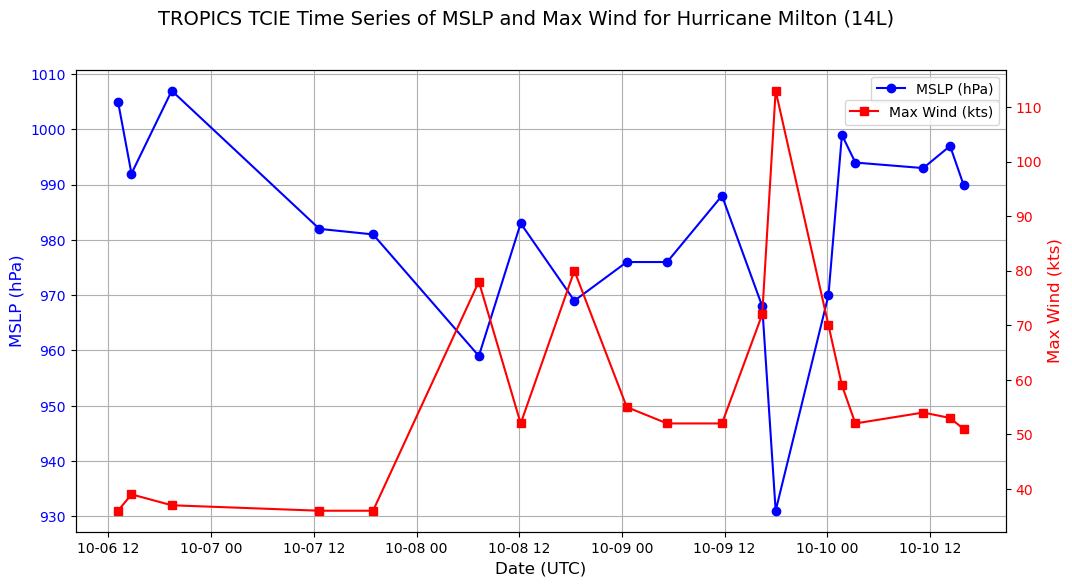

In [329]:
# Select where stmnum equals 14 (MILTON14L)
ds_milton = final_combined.where(final_combined.stmnum == 14, drop=True)

# Select variables and reduce dimensions for plotting
mslp = ds_milton['mslp'].isel(mslpd=0, stm_num=0)
max_wind = ds_milton['max_wind'].isel(vmax=0, stm_num=0)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MSLP on the first y-axis
ax1.plot(mslp['time'], mslp, label="MSLP (hPa)", color="blue", marker="o")
ax1.set_xlabel("Date (UTC)", fontsize=12)
ax1.set_ylabel("MSLP (hPa)", fontsize=12, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid()

# Create a second y-axis for max wind
ax2 = ax1.twinx()
ax2.plot(max_wind.time, max_wind, label="Max Wind (kts)", color="red", marker="s")
ax2.set_ylabel("Max Wind (kts)", fontsize=12, color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add a title and legend
fig.suptitle("TROPICS TCIE Time Series of MSLP and Max Wind for Hurricane Milton (14L)", fontsize=14)
ax1.legend(loc="upper right")
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.95))

plt.show()
